In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt

/Users/alfredonuada/miniconda/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# this makes sure GPU is allocated on demand not upfront
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [3]:
DATASET_NAME = "rock_paper_scissors"

(df_train, df_val), info = tfds.load(
    name=DATASET_NAME,
    with_info=True,
    split=[tfds.Split.TRAIN, tfds.Split.TEST],
    as_supervised=True,
    data_dir='tmp',
    batch_size=32,
    shuffle_files=True
)

Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



In [4]:
info.splits

{'train': <SplitInfo num_examples=2520, num_shards=2>,
 'test': <SplitInfo num_examples=372, num_shards=1>}

In [8]:
info.features['label'].names

['rock', 'paper', 'scissors']

In [5]:
# this is simply just changing the name to a suitable one
get_label_name_from_label_index = info.features['label'].int2str

def preview_images(dataset):
  plt.figure(figsize=(12, 12))
  plot_index = 0
  for features in dataset.take(12):
    (image, label) = features
    plot_index += 1
    plt.subplot(3, 4, plot_index)

    label_idx = label.numpy()
    label = get_label_name_from_label_index(label_idx)
    plt.title(f'Label {label} {label_idx}')
    plt.imshow(image.numpy())

2023-08-11 22:26:40.514034: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


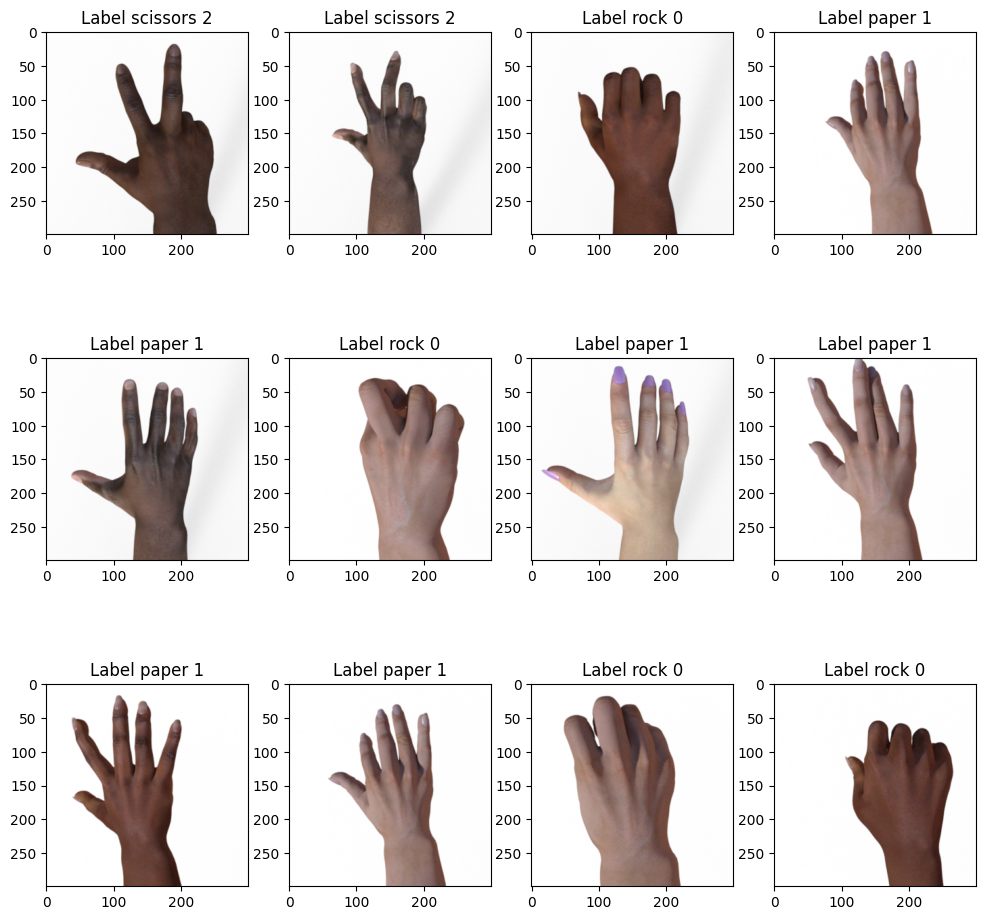

In [6]:
preview_images(df_train.unbatch())

## PREPROCESSING

In [7]:
print(f'IMAGE SIZE (height, width, channels): {info.features["image"].shape}')

IMAGE SIZE (height, width, channels): (300, 300, 3)


In [8]:

IMG_SIZE_ORIGINAL = info.features['image'].shape[0]
IMG_SIZE_REDUCED = IMG_SIZE_ORIGINAL // 2
IMG_CHANNELS = info.features['image'].shape[2]

def reduce_image_size(image, label):
  # change all values to float (without changing when you divide the decimal
  # part will be lost)
  image = tf.cast(image, tf.float32)
  # change all values to be between 0 and 1
  image = image / 255
  image = tf.image.resize(image, [IMG_SIZE_REDUCED, IMG_SIZE_REDUCED])

  return image, label


In [52]:
IMG_SIZE_REDUCED

150

In [9]:
df_train_reshaped = df_train.map(reduce_image_size)
df_val_reshaped = df_val.map(reduce_image_size)

# create test set
df_test = df_val_reshaped.take(1)
df_val_reshaped = df_val_reshaped.skip(1)

In [11]:
# preview_images(df_train_reshaped.unbatch())

In [12]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, RandomFlip, RandomRotation, RandomZoom, RandomContrast, RandomBrightness

In [13]:
MIN_BRIGHTNESS = -0.6
MAX_BRIGHTNESS = 0.6

augmentation_layer = Sequential([
    RandomFlip(input_shape=(IMG_SIZE_REDUCED, IMG_SIZE_REDUCED, IMG_CHANNELS)),
    RandomRotation(0.1),
    RandomZoom(0.2),
    RandomBrightness((MIN_BRIGHTNESS, MAX_BRIGHTNESS), value_range=(0,1)),
    RandomContrast(0.5)
])

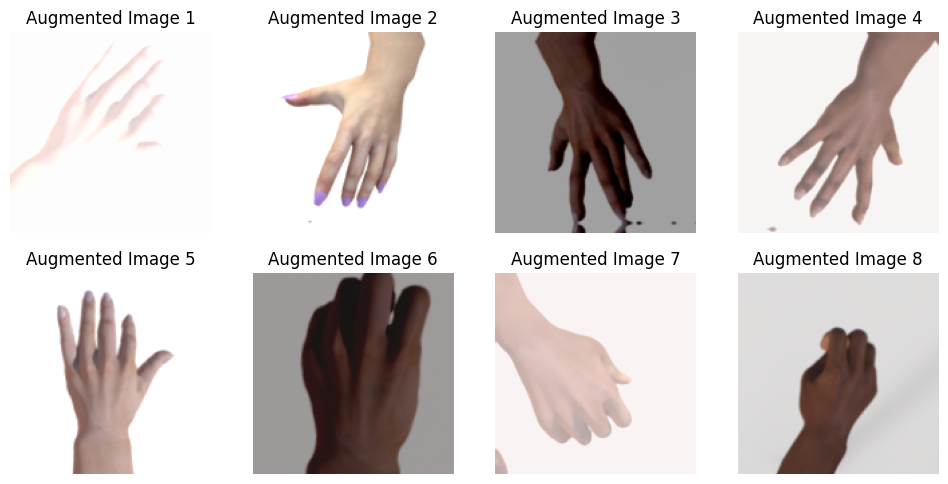

In [14]:
plt.figure(figsize=(12, 12))
plot_index = 0
for (image, label) in df_train_reshaped.unbatch():
    # Apply augmentation
    augmented_image = augmentation_layer(tf.expand_dims(image, axis=0), training=True)

    plot_index += 1
    plt.subplot(4, 4, plot_index)
    plt.imshow(tf.squeeze(augmented_image).numpy().astype(float))  # Convert to NumPy array for visualization
    plt.title(f"Augmented Image {plot_index}")
    plt.axis('off')

    if plot_index == 8:
        break

plt.show()

In [16]:
NUM_CLASSES = info.features['label'].num_classes

model = Sequential([
    augmentation_layer,
    Conv2D(64, (3, 3), 1, activation='relu', input_shape=(IMG_SIZE_REDUCED, IMG_SIZE_REDUCED, IMG_CHANNELS)),
    MaxPooling2D(),
    Conv2D(128, (3, 3), 1, activation='relu'),
    MaxPooling2D(),
    Dropout(0.3),
    Conv2D(32, (3, 3), 1, activation='relu'),
    MaxPooling2D(),
    Flatten(),
    Dropout(0.3),
    Dense(512, activation='relu'),
    Dropout(0.3),
    Dense(256, activation='relu'),
    Dense(128, activation='relu'),
    Dense(NUM_CLASSES, activation='softmax') # softmax is a multi-class activation function
])

In [17]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 150, 150, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 148, 148, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 128)       73856     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 36, 36, 128)      0         
 2D)                                                             
                                                                 
 dropout (Dropout)           (None, 36, 36, 128)      

In [18]:
# tf.keras.utils.plot_model(
#     model,
#     show_shapes=True,
#     show_layer_names=True,
# )

In [19]:
model.compile(
    optimizer='adam',
    loss=tf.losses.sparse_categorical_crossentropy, # because the labels are 0,1,2 not one hot encoded
    metrics=['accuracy']
)

In [20]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    min_delta=0.01,
    patience=5,
    restore_best_weights=True
)

In [21]:
# auto adjust leanring rate
from tensorflow.keras.callbacks import ReduceLROnPlateau

reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.2, patience=5, min_lr=0.0001)

In [22]:
hist = model.fit(
    df_train_reshaped,
    epochs=60,
    validation_data=df_val_reshaped,
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/60
79/79 [==============================] - 10s 111ms/step - loss: 1.1097 - accuracy: 0.3278 - val_loss: 1.0983 - val_accuracy: 0.3294 - lr: 0.0010
Epoch 2/60
79/79 [==============================] - 8s 96ms/step - loss: 1.0706 - accuracy: 0.4083 - val_loss: 0.9428 - val_accuracy: 0.6735 - lr: 0.0010
Epoch 3/60
79/79 [==============================] - 8s 96ms/step - loss: 0.9433 - accuracy: 0.5202 - val_loss: 0.8485 - val_accuracy: 0.6794 - lr: 0.0010
Epoch 4/60
79/79 [==============================] - 8s 96ms/step - loss: 0.7647 - accuracy: 0.6306 - val_loss: 0.5102 - val_accuracy: 0.7765 - lr: 0.0010
Epoch 5/60
79/79 [==============================] - 8s 96ms/step - loss: 0.6110 - accuracy: 0.7246 - val_loss: 0.5374 - val_accuracy: 0.7794 - lr: 0.0010
Epoch 6/60
79/79 [==============================] - 8s 96ms/step - loss: 0.4951 - accuracy: 0.7933 - val_loss: 0.4058 - val_accuracy: 0.8000 - lr: 0.0010
Epoch 7/60
79/79 [==============================] - 8s 96ms/step - loss: 0

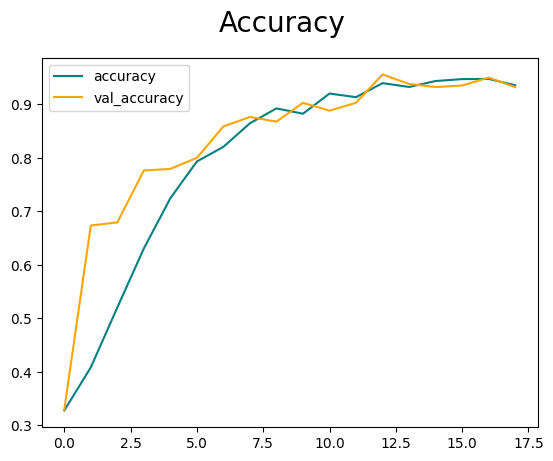

In [23]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc='upper left')
plt.show()

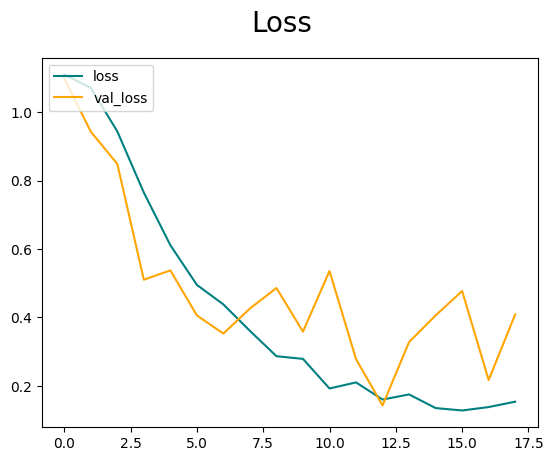

In [24]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc='upper left')
plt.show()

In [25]:
total_train_samples = len(hist.history['loss']) * 256
print("Total number of input images used for training:", total_train_samples)

Total number of input images used for training: 4608


# Save the model

In [26]:
model.save('rps_model.h5')

In [46]:
model.evaluate(df_test)

1/1 [==============================] - 0s 185ms/step - loss: 0.0551 - accuracy: 0.9688


[0.05512269213795662, 0.96875]

In [ ]:
# convert the model to the js version
